## LLM performance

In [26]:
import datasets

with open("1000_predictions.txt") as f:
    outputs = [int(line.strip()) for line in f.readlines()]

imdb_dataset = datasets.load_from_disk('1000_sampled_imdb')
labels = imdb_dataset['label']

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(outputs)):
    if labels[i] == 1 and outputs[i] != 2:
        pos_total += 1
        if outputs[i] == labels[i]:
            pos_correct += 1
    elif labels[i] == 0 and outputs[i] != 2:
        neg_total += 1
        if outputs[i] == labels[i]:
            neg_correct += 1

print("Total accuracy: ", (pos_correct + neg_correct) / (pos_total + neg_total))
print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

Total accuracy:  0.93993993993994
Positive accuracy:  0.924
Negative accuracy:  0.9559118236472945


In [3]:
pos_correct, pos_total, neg_correct, neg_total

(462, 500, 477, 499)

## LLM labels as proxy

#### dataset & library import

In [27]:
# plot the accuracy changes as we adjust the number of samples
import matplotlib.pyplot as plt
import numpy as np
# beautify the plot
plt.style.use('seaborn-darkgrid')

/tmp/ipykernel_672274/221098722.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [28]:
import datasets
# Load the dataset
imdb_data = datasets.load_from_disk("1000_sampled_imdb")

#### td-idf as word embeddings

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

texts = imdb_data["text"]  # list of texts to classify
labels = imdb_data["label"]  # list of texts to classify

vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 1), lowercase=True)

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

with open("1000_predictions.txt") as f:
    llama_labels = [int(line) for line in f.readlines()]

filtered_texts, filtered_llama_labels, filtered_labels = [], [], []
for t, l, g in zip(texts, llama_labels, labels):
    if l != 2:
        filtered_texts.append(t)
        filtered_llama_labels.append(l)
        filtered_labels.append(g)

# Split the data into training and test sets
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(filtered_texts, filtered_llama_labels, test_size=0.2, random_state=42)
# calculate baseline accuracy for the proxy labels
baseline_acc = accuracy_score(y_test_gold, y_test_proxy)

X_train_proxy = vectorizer.fit_transform(X_train_proxy)
X_test_proxy = vectorizer.transform(X_test_proxy)

_, _, _, y_test_gold = train_test_split(filtered_texts, filtered_labels, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_proxy, y_train_proxy)

# Make predictions on the test set
y_pred_proxy = classifier.predict(X_test_proxy)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_gold, y_pred_proxy)
print("Accuracy:", accuracy)

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_proxy)):
    if y_test_gold[i] == 1:
        pos_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

0.94
Accuracy: 0.845
Positive accuracy:  0.8235294117647058
Negative accuracy:  0.8673469387755102


In [8]:
pos_correct, pos_total - pos_correct, neg_correct, neg_total - neg_correct

(84, 18, 85, 13)

In [9]:
pos_total, neg_total

(102, 98)

In [10]:
import eli5

eli5.show_weights(estimator=classifier, 
                  feature_names= list(vectorizer.get_feature_names_out()),
                 top=(10, 10))

Weight?,Feature
+1.964,great
+1.043,excellent
+1.027,fun
+0.995,love
+0.969,perfect
+0.923,best
+0.893,beautiful
+0.890,life
+0.869,series
+0.816,shows


#### sentence-bert as word embeddings

In [79]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

texts = imdb_data["text"]  # list of texts to classify
labels = imdb_data["label"]  # list of texts to classify

# Encode the training set
texts = model.encode(texts)

In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

with open("1000_predictions.txt") as f:
    llama_labels = [int(line) for line in f.readlines()]

filtered_texts, filtered_llama_labels, filtered_labels = [], [], []
for t, l, g in zip(texts, llama_labels, labels):
    if l != 2:
        filtered_texts.append(t)
        filtered_llama_labels.append(l)
        filtered_labels.append(g)

    
# Split the data into training and test sets
X_train_proxy, X_test_proxy, y_train_proxy, y_test_proxy = train_test_split(filtered_texts, filtered_llama_labels, test_size=0.2, random_state=42)
_, _, _, y_test_gold = train_test_split(filtered_texts, filtered_labels, test_size=0.2, random_state=42)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_proxy, y_train_proxy)

# Make predictions on the test set
y_pred_proxy = classifier.predict(X_test_proxy)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_gold, y_pred_proxy)
print("Accuracy:", accuracy)

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_proxy)):
    if y_test_gold[i] == 1:
        pos_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

Accuracy: 0.77
Positive accuracy:  0.7549019607843137
Negative accuracy:  0.7857142857142857


In [13]:
pos_correct, pos_total - pos_correct, neg_correct, neg_total - neg_correct

(77, 25, 77, 21)

### RQ - Confidence threshold

In [31]:
classifier.decision_function(X_test_proxy)[0]

0.4537686704792407

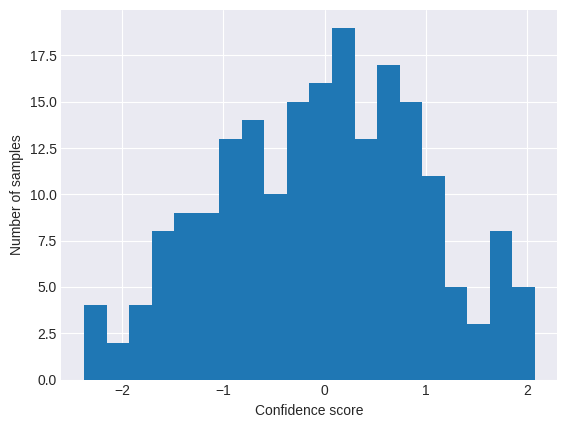

In [58]:
# plot a bar chart of the distribution of the confidence scores
plt.hist(classifier.decision_function(X_test_proxy), bins=20)
plt.xlabel("Confidence score")
plt.ylabel("Number of samples")
plt.show()


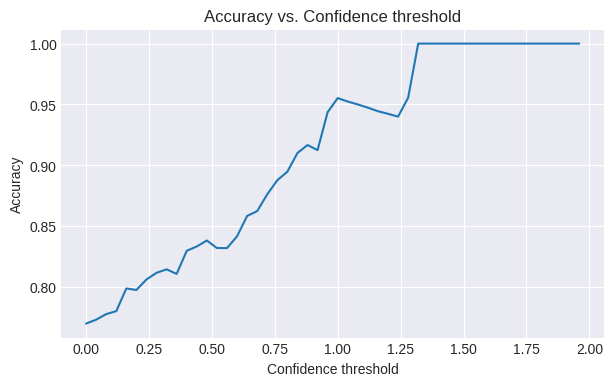

In [81]:
confidence = classifier.decision_function(X_test_proxy)
acc = []
to = []
scale = round(max(confidence), 0)
num_steps = 50
for k in range(num_steps):
    total, count = 0, 0
    for i in range(len(y_pred_proxy)):
        if abs(confidence[i]) > k/num_steps*scale:
            total += 1
            if y_pred_proxy[i] == y_test_gold[i]:
                count += 1
    to.append(total)
    acc.append(count / total)

plt.plot([i/num_steps*scale for i in range(num_steps)], acc)
plt.xlabel("Confidence threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Confidence threshold")
plt.gcf().set_size_inches(7, 4)
# plt.savefig('confidence.png', dpi=300)
plt.show()

Max accuracy:  0.945
Threshold:  1.32


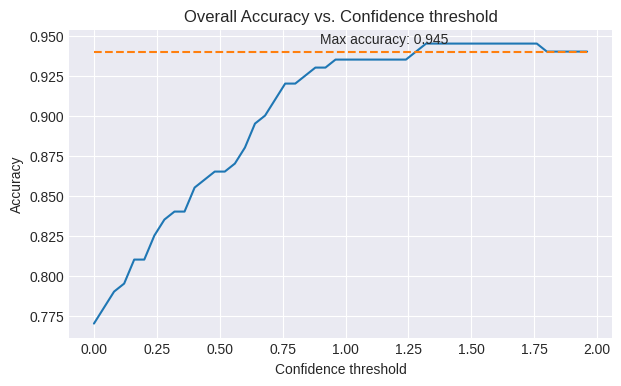

In [88]:
confidence = classifier.decision_function(X_test_proxy)
acc = []
to = []
scale = round(max(confidence), 0)
for k in range(num_steps):
    total, count = 0, 0
    for i in range(len(y_pred_proxy)):
        total += 1
        if abs(confidence[i]) > k/num_steps*scale:
            label_we_use = y_pred_proxy[i]
        else:
            label_we_use = y_test_proxy[i]
        
        if label_we_use == y_test_gold[i]:
            count += 1
    acc.append(count / total)

# calculate the threshold for the max accuracy
max_acc = max(acc)
max_acc_index = acc.index(max_acc)
threshold = max_acc_index/num_steps*scale
print("Max accuracy: ", max_acc)
print("Threshold: ", threshold)


plt.plot([i/num_steps*scale for i in range(num_steps)], acc)
plt.plot([i/num_steps*scale for i in range(num_steps)], [baseline_acc for _ in range(num_steps)], linestyle='--')
# show max accuracy on the plot
plt.annotate(f"Max accuracy: {max(acc)}", (0.9, max(acc)))
plt.xlabel("Confidence threshold")
plt.ylabel("Accuracy")
plt.title("Overall Accuracy vs. Confidence threshold")
plt.gcf().set_size_inches(7, 4)
# plt.savefig('confidence.png', dpi=300)
plt.show()

In [89]:
# count the number of samples above a certain confidence threshold
confidence = classifier.decision_function(X_test_proxy)
total, count = 0, 0
for i in range(len(y_pred_proxy)):
    if abs(confidence[i]) > threshold:
        total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            count += 1
print("Accuracy:", count / total)
print("Total samples:", count)


Accuracy: 1.0
Total samples: 39


### RQ - Change training data size

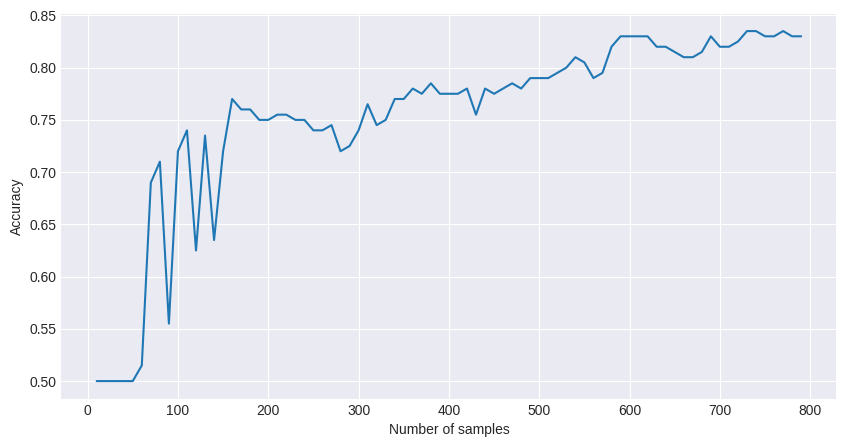

In [197]:
accuracies = []
X_len = X_train_proxy.shape[0]
y_len = len(y_train_proxy)
for i in range(1, 80):
    # Split the data into training and test sets
    X_train_proxy_sampled, y_train_proxy_sampled = X_train_proxy[:min(i*10,X_len)], y_train_proxy[:min(i*10,y_len)]
    # Train a logistic regression classifier
    classifier = LogisticRegression()
    classifier.fit(X_train_proxy_sampled, y_train_proxy_sampled)
    

    # Make predictions on the test set
    y_pred_proxy_sampled = classifier.predict(X_test_proxy)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test_proxy, y_pred_proxy_sampled)
    accuracies.append(accuracy)

plt.plot(np.arange(10, 800, 10), accuracies)
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
# set size
plt.gcf().set_size_inches(10, 5)
plt.savefig('accuracy.png', dpi=300)

### RQ - Manually adjust label distribution

In [205]:
num_samples_idx=8
X_train_proxy_sampled, y_train_proxy_sampled = X_train_proxy[:min(num_samples_idx*10,X_len)], y_train_proxy[:min(num_samples_idx*10,y_len)]
# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_proxy_sampled, y_train_proxy_sampled)

# Make predictions on the test set
y_pred_proxy_sampled = classifier.predict(X_test_proxy)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_proxy, y_pred_proxy_sampled)
print("Accuracy:", accuracy)

# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_proxy_sampled)):
    if y_test_proxy[i] == 1:
        pos_total += 1
        if y_pred_proxy_sampled[i] == y_test_proxy[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_proxy_sampled[i] == y_test_proxy[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

Accuracy: 0.71
Positive accuracy:  0.91
Negative accuracy:  0.51


In [206]:
import scipy
# put more negative samples into training data
new_negative_samples = []
new_positive_samples = []
for x, y in zip(X_train_proxy[:][min(num_samples_idx*10,X_len):], y_train_proxy[:][min(num_samples_idx*10,y_len):]):
    if y == 0:
        new_negative_samples = scipy.sparse.vstack([new_negative_samples, x]).tocsr()
    else:
        new_positive_samples = scipy.sparse.vstack([new_positive_samples, x]).tocsr()
print(new_negative_samples.shape, new_positive_samples.shape)

(377, 15914) (344, 15914)


In [209]:
new_accuracy, new_pos_accuracy, new_neg_accuracy = [accuracy], [pos_correct / pos_total], [neg_correct / neg_total]
num_new_samples = 10
for k in range(num_new_samples):
    X_train_proxy_sampled_plus = scipy.sparse.vstack([X_train_proxy[:min(num_samples_idx*10,X_len)], new_negative_samples[:k]])
    y_train_proxy_sampled_plus = y_train_proxy[:min(num_samples_idx*10,y_len)] + [0] * k

    # Train a logistic regression classifier
    classifier = LogisticRegression()
    classifier.fit(X_train_proxy_sampled_plus, y_train_proxy_sampled_plus)

    # Make predictions on the test set
    y_pred_proxy_sampled_plus = classifier.predict(X_test_proxy)

    # Evaluate the accuracy of the classifier
    accuracy = accuracy_score(y_test_proxy, y_pred_proxy_sampled_plus)
    new_accuracy.append(accuracy)

    # calculate accuracy for each class
    pos_correct = 0
    pos_total = 0
    neg_correct = 0
    neg_total = 0
    for i in range(len(y_pred_proxy_sampled_plus)):
        if y_test_proxy[i] == 1:
            pos_total += 1
            if y_pred_proxy_sampled_plus[i] == y_test_proxy[i]:
                pos_correct += 1
        else:
            neg_total += 1
            if y_pred_proxy_sampled_plus[i] == y_test_proxy[i]:
                neg_correct += 1
                
    new_pos_accuracy.append(pos_correct / pos_total)
    new_neg_accuracy.append(neg_correct / neg_total)

[0.5, 0.71, 0.76, 0.755, 0.715, 0.635, 0.585, 0.555, 0.54, 0.53, 0.52]


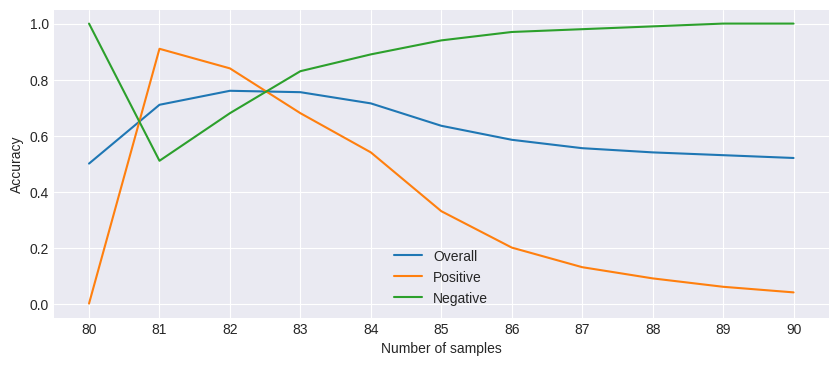

In [211]:
# plot the accuracy changes as we adjust the number of samples
plt.plot(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1), new_accuracy)
plt.plot(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1), new_pos_accuracy)
plt.plot(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1), new_neg_accuracy)
plt.xlabel("Number of samples")
plt.ylabel("Accuracy")
# set x-axis split
plt.xticks(np.arange(num_samples_idx*10, num_samples_idx*10+num_new_samples+1, 1))
# set size
plt.gcf().set_size_inches(10, 4)
plt.savefig('accuracy_change.png', dpi=300)
plt.legend(["Overall", "Positive", "Negative"])
print(new_accuracy)


## Training with Ground Truth

In [213]:

# Split the data into training and test sets
X_train_gold, X_test_gold, y_train_gold, y_test_gold = train_test_split(filtered_texts, filtered_labels, test_size=0.2, random_state=42)

X_train_gold = vectorizer.fit_transform(X_train_gold)
X_test_gold = vectorizer.transform(X_test_gold)

# Train a logistic regression classifier
classifier = LogisticRegression()
classifier.fit(X_train_gold, y_train_gold)

# Make predictions on the test set
y_pred_gold = classifier.predict(X_test_gold)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test_gold, y_pred_gold)
print("Accuracy:", accuracy)


# calculate accuracy for each class
pos_correct = 0
pos_total = 0
neg_correct = 0
neg_total = 0
for i in range(len(y_pred_proxy)):
    if y_test_gold[i] == 1:
        pos_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            pos_correct += 1
    else:
        neg_total += 1
        if y_pred_proxy[i] == y_test_gold[i]:
            neg_correct += 1

print("Positive accuracy: ", pos_correct / pos_total)
print("Negative accuracy: ", neg_correct / neg_total)

Accuracy: 0.845
Positive accuracy:  0.8235294117647058
Negative accuracy:  0.8673469387755102


In [ ]:
pos_correct, pos_total, neg_correct, neg_total